# Check Dataset

In [1]:
import json

with open("../environment.json", "r") as f:
    env = json.load(f)

In [2]:
!ls /data1/meta_midi_dataset

5				    MMD_md5_metainfo.tsv
6				    MMD_md5_to_mbid.json
MMD_MIDI			    MMD_md5_to_mbid_audio_text.json
MMD_audio_matched_genre.jsonl	    MMD_scraped_genre.jsonl
MMD_audio_matches.tsv		    MMD_scraped_site_midi_counts.json
MMD_audio_text_matched_genre.jsonl  MMD_scraped_title_artist.jsonl
MMD_audio_text_matches.tsv	    MMD_sid_to_mbid.json
MMD_copyright.txt		    md5_to_genre.json
MMD_md5_metainfo.csv		    spotify_sample


In [3]:
import os
import sys
from glob import glob

import librosa
import pandas as pd

sys.path.append(os.path.abspath("../"))


/home/atsuya/.pyenv/versions/anaconda3-2020.11/envs/album-covers-vqvae/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [4]:
from src.datasets import MMD_audio_matched_genre, MMD_audio_matches, MMD_scraped_title_artist

2022-08-22 14:39:41,315 - datasets.py - INFO - Loading MMD_audio_matched_genre data
2022-08-22 14:39:41,641 - datasets.py - INFO - Loading MMD_scraped_title_artist data
2022-08-22 14:39:43,003 - datasets.py - INFO - Loading MMD_md5_metainfo data
2022-08-22 14:39:43,161 - datasets.py - INFO - Loading MMD_audio_matches data


In [5]:
MMD_scraped_title_artist[0]

{'md5': 'be51e8259904879e561850e140e997dd',
 'title_artist': [["'Tis break of day", 'Henry Thomas Smart']]}

In [17]:
MMD_scraped_title_artist_df = pd.DataFrame(MMD_scraped_title_artist)
title = [ta[0][0] for ta in MMD_scraped_title_artist_df.title_artist.values]
artist = [ta[0][1] for ta in MMD_scraped_title_artist_df.title_artist.values]

MMD_scraped_title_artist_df["title"] = title
MMD_scraped_title_artist_df["artist"] = artist

MMD_scraped_title_artist_df.head()

,md5,title_artist,title,artist
0,be51e8259904879e561850e140e997dd,"[['Tis break of day, Henry Thomas Smart]]",'Tis break of day,Henry Thomas Smart
1,272257791018b3c151029b49734b26a6,"[[Ave Maria, Fabio Fresi]]",Ave Maria,Fabio Fresi
2,2596615b7dc995ff733995786fb6dc64,"[[Lukaspassion, Heinrich Schütz]]",Lukaspassion,Heinrich Schütz
3,17b545f91caf271920727ee61f21e494,"[[An Wasserflüssen Babylon, BWV 267, Johann Se...","An Wasserflüssen Babylon, BWV 267",Johann Sebastian Bach
4,4f8ee1160e87907d56d864b5dd75b61a,"[[Matthäuspassion, Heinrich Schütz]]",Matthäuspassion,Heinrich Schütz


In [15]:
MMD_audio_matched_genre[0]

{'md5': 'ac45c832a78728aa8822a3df637682c3',
 'genre_discogs': {'electronic': 49,
  'electronic---synth-pop': 49,
  'folk, world, & country': 1,
  'folk, world, & country---country': 1,
  'pop': 49},
 'genre_tagtraum': {'country': 1,
  'country---contemporarycountry': 1,
  'country---neotraditionalcountry': 1,
  'soundtrack': 49,
  'soundtrack---broadway': 49,
  'soundtrack---musical': 49},
 'genre_lastfm': {'country': 1,
  'rock': 49,
  'rock---classicrock': 49,
  'rock---softrock': 49}}

In [13]:
import pandas as pd
from tqdm import tqdm

score_threshold = 10
# score_threshold = all_scores.score.mean()


def extract_genres_str(genres: str) -> list:
    return genres.replace("{", "").replace("}", "").split(",")


all_song_genres = []
for idx, d in tqdm(enumerate(MMD_audio_matched_genre)):
    md5 = d["md5"]
    base_genres_per_sites = []
    sub_genres_per_sites = []
    for site in ["genre_discogs", "genre_tagtraum", "genre_lastfm"]:
        if genre_d := d.get(site, None):
            for g, s in genre_d.items():
                if s > score_threshold:
                    if "---" in g:
                        sub_genres_per_sites.append(g)
                    else:
                        base_genres_per_sites.append(g)
    base_genres_per_sites = list(set(base_genres_per_sites))
    sub_genres_per_sites = list(set(sub_genres_per_sites))
    if len(base_genres_per_sites) > 0:
        all_song_genres.append(
            [md5, base_genres_per_sites, sub_genres_per_sites])
all_song_genres = pd.DataFrame(all_song_genres, columns=["md5", "base", "sub"])


55894it [00:00, 362405.40it/s]


In [14]:
all_song_genres.head()

,md5,base,sub
0,ac45c832a78728aa8822a3df637682c3,"[pop, electronic, rock, soundtrack]","[rock---softrock, rock---classicrock, soundtra..."
1,a9544a68c5ca8e32c224f25d5a06619d,"[rock, rock/pop]","[rock---punk, rock/pop---punk, rock/pop---punk..."
2,977ff912c999669cd10d670d45ac703b,[classical],[classical---classicalsoloinstrumental]
3,ac547baef487103fd9de9f49d2f6e204,"[pop, electronic, rock/pop, funk / soul]","[pop---disco, pop---dancepop, pop---europop, e..."
4,aa42e141c3e3ff1f46e9bc676ca61ebb,[classical],[classical---baroque]


In [13]:
MMD_audio_matches.head()

,md5,score,sid
0,977349d0bec3fed4bd2bef1b57c597d4,0.554720,5n3es2C6R47r4WGfmYL9vZ
1,a8ab220d3e771f14994bcb6104a6e733,0.910470,65yDyFGWY1nAAEIoPoGSL6
2,a8ab220d3e771f14994bcb6104a6e733,0.743186,6WRwxMiwig6czraGVt3xEB
3,a8ab220d3e771f14994bcb6104a6e733,0.775063,6X72YoEcN8Iuw4e70NMb1V
4,a8ab220d3e771f14994bcb6104a6e733,0.675244,1Yg4ZDCR9z6AEHwEuWqNAe


In [31]:
MMD_all = pd.merge(MMD_audio_matches, MMD_scraped_title_artist_df, on="md5")
MMD_all = pd.merge(MMD_all, all_song_genres, on="md5")

MMD_all.sort_values("score", inplace=True)
MMD_all.drop_duplicates(subset="md5", keep="first", inplace=True)
MMD_all.drop(columns=["title_artist"], inplace=True)
print(MMD_all[MMD_all.score > 0.8].describe())
MMD_all[MMD_all.score > 0.9].head()

           score
count  17.000000
mean    0.889073
std     0.055814
min     0.814513
25%     0.850158
50%     0.875398
75%     0.925743
max     1.000000


,md5,score,sid,title,artist,base,sub
83809,79db3302bbe75167079b4974d79aa216,0.912302,4kVY0FrIQBfwpGQWMcewDR,Twelve Duets k.487 no.2,"Mozart, Wolfgang Amadeus",[classical],[classical---classical]
95974,ba60a18268ba612702ee86940f9afbbf,0.925743,6VhYeAS9fjVJGGMpO3wq0G,Fuga 13 Fa Diez - Mazhor,Dmitriy Dmitrievich Shostakovich (1906-1975),[classical],[classical---modern]
179412,7c2586b503dce697132bc6894c9aece4,0.949332,5dkYMpfqzleedQOGxfb5fh,Fuga 19 Mi Bemol - Mazhor,Dmitriy Dmitrievich Shostakovich (1906-1975),[classical],[classical---modern]
312490,f9de28d2116556f05a0e04ad68150855,0.962327,5IpQVXCqxomnslCpYBKjLN,Fuga 11 B - Mazhor,Dmitriy Dmitrievich Shostakovich (1906-1975),[classical],[classical---modern]
143149,ec981e208ec1415a72ccfd4ab5ef4945,0.964796,6XGH7h97RrnrRnkiav4jyb,Prelyudiya 11 Si - Mazhor,Dmitriy Dmitrievich Shostakovich (1906-1975),[classical],[classical---modern]


<AxesSubplot:>

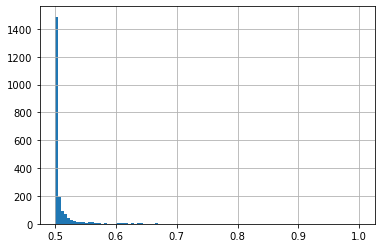

In [33]:
MMD_all.score.hist(bins=100)

## Genre-Combined MetaData

In [4]:
import os
import pandas as pd

MMD_md5_metainfo = pd.read_csv(os.path.join(env["DATASET_PATH"], "MMD_md5_metainfo.csv"))
MMD_md5_metainfo.head()

,Unnamed: 0,md5,artist,title,genre
0,0,be51e8259904879e561850e140e997dd,Henry Thomas Smart,'Tis break of day,romantic
1,1,272257791018b3c151029b49734b26a6,Fabio Fresi,Ave Maria,modern
2,2,2596615b7dc995ff733995786fb6dc64,Heinrich Schütz,Lukaspassion,baroque
3,3,17b545f91caf271920727ee61f21e494,Johann Sebastian Bach,"An Wasserflüssen Babylon, BWV 267",baroque
4,4,4f8ee1160e87907d56d864b5dd75b61a,Heinrich Schütz,Matthäuspassion,baroque


In [5]:
MMD_md5_metainfo[MMD_md5_metainfo.genre == "rock"][["artist", "title"]].values.tolist()

[['Alice in Chains', 'Nutshell'],
 ['Styx', 'Too Much Time On My Hands'],
 ['Bryan Adams', 'All For Love'],
 ['Billy Joel', 'Pressure.2'],
 ['Eagles', 'Hotel\nCalifornia'],
 ['Aerosmith', 'Walk This Way'],
 ['Van Halen', 'Pleasure Dome'],
 ['Starship', 'We Built This City (Karaoke)'],
 ['Styx', "Don't Let It End"],
 ['Supergrass', 'Alright (Karaoke)'],
 ['Red Hot Chilli Peppers', 'Aeroplane'],
 ['Peter Gabriel', 'In Your Eyes'],
 ['Parsons Project, Alan', 'The-System-Of-Dr-Tarr-&-Professor-Fether'],
 ['Collective Soul', 'Gel'],
 ['Bush', 'Cold Contagious'],
 ['Alice In Chains', 'Sludge Factory'],
 ['Jimi Hendrix', 'Purple Haze.3'],
 ['White Zombie', 'Black Sunshine'],
 ['Alice In Chains', 'Over Now'],
 ['Yes', 'Love Will Find a Way'],
 ['Alice In Chains', 'Dont Follow'],
 ['ACDC', 'Back In Black'],
 ['Alice in Chains', 'What the Hell Have I'],
 ['Aerosmith', 'Falling In Love ( Is Hard On The Knees)'],
 ['Weezer', 'Tired Of Sex'],
 ['Yes', 'Long Distance Runaround.1'],
 ['Guns & Roses',